In [ ]:
#init 

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
df = pd.read_csv("./villes_france_30000.csv")
villes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
villes.set_crs("EPSG:4326")

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
1,2,13200,Marseille,43.300,5.400,800550,POINT (5.40000 43.30000)
2,3,69380,Lyon,45.750,4.850,415487,POINT (4.85000 45.75000)
3,4,31555,Toulouse,43.600,1.433,358688,POINT (1.43300 43.60000)
4,5,6088,Nice,43.700,7.250,342439,POINT (7.25000 43.70000)
...,...,...,...,...,...,...,...
29995,29996,52195,Farincourt,47.700,5.683,68,POINT (5.68300 47.70000)
29996,29997,70090,Boursieres,47.617,6.050,68,POINT (6.05000 47.61700)
29997,29998,54224,Germonville,48.400,6.217,68,POINT (6.21700 48.40000)
29998,29999,73049,Bonvillaret,45.567,6.300,68,POINT (6.30000 45.56700)


In [4]:
from shapely.geometry import Polygon

In [5]:
ile_de_france=Polygon([(2.91, 48.52),(2.91, 49.12),(1.82, 49.12),(1.82, 48.52)])

In [6]:
cities = villes[(~villes.geometry.within(ile_de_france)) | (villes["nom"] == "Paris")]

In [7]:
final_cities=cities[:100]
final_cities

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
1,2,13200,Marseille,43.300,5.400,800550,POINT (5.40000 43.30000)
2,3,69380,Lyon,45.750,4.850,415487,POINT (4.85000 45.75000)
3,4,31555,Toulouse,43.600,1.433,358688,POINT (1.43300 43.60000)
4,5,6088,Nice,43.700,7.250,342439,POINT (7.25000 43.70000)
...,...,...,...,...,...,...,...
139,140,58194,Nevers,46.983,3.167,41968,POINT (3.16700 46.98300)
140,141,60159,Compiegne,49.417,2.833,41896,POINT (2.83300 49.41700)
141,142,69290,Saint-Priest,45.692,4.933,41876,POINT (4.93300 45.69200)
142,143,6030,LeCannet,43.567,7.017,41842,POINT (7.01700 43.56700)


,idx,INSEE,nom,latitude,longitude,population,geometry
72,73,10387,Troyes,48.3,4.083,59255,POINT (4.08300 48.30000)


<AxesSubplot:>

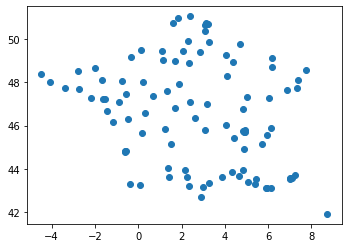

In [8]:
final_cities.plot()

In [9]:
MAX_DIST = 1.6
graphe = final_cities
g = {nom: {} for nom in graphe.nom}

prev = None
for i in range(len(graphe)):
    dist = graphe.iloc[i+1:].distance(graphe.iloc[i].geometry)
    for j, d in enumerate(dist):
        if d < MAX_DIST:
            g[graphe.iloc[i].nom][graphe.iloc[i + j + 1].nom] = {"weight": d}
            g[graphe.iloc[i + j + 1].nom][graphe.iloc[i].nom] = {"weight": d}

    if (int(i / len(graphe) * 100) % 10 == 0) and (int(i / len(graphe) * 100) != prev):
        prev = int(i / len(graphe) * 100)
        print(str(prev)+"% effectué")

0% effectué
10% effectué
20% effectué
30% effectué
40% effectué
50% effectué
60% effectué
70% effectué
80% effectué
90% effectué


In [10]:
import networkx as nx
G = nx.from_dict_of_dicts(g)

In [11]:
len(G) #number of edges

100

In [12]:
G.number_of_edges() #number of vertices 

420

In [257]:
#list(nx.connected_components(G)) #10 composantes connexes 
#il va falloir connecter les composantes connexes (Marseille -> Lille par exemple est impossible)

In [13]:
import matplotlib.pyplot as plt

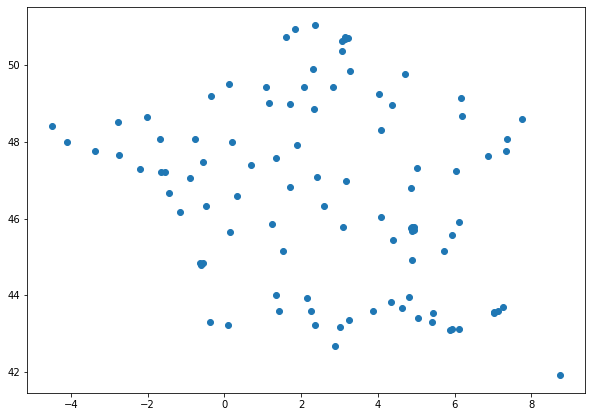

In [14]:
#on trace les points avec matplotlib
fig, ax = plt.subplots(figsize=(10, 10)) 

graphe.plot(ax=ax)

plt.show()

In [15]:
from shapely.geometry import LineString

In [16]:
rows = []
for (u, v) in G.edges:
    p1 = graphe[graphe["nom"] == u].geometry.iloc[0]
    p2 = graphe[graphe["nom"] == v].geometry.iloc[0]
    
    row = {'orig': u, 
           'dest': v,
           'geometry': LineString([p1, p2])}
    rows.append(row)

In [17]:
gdf = gpd.GeoDataFrame(rows, crs="EPSG:4326")

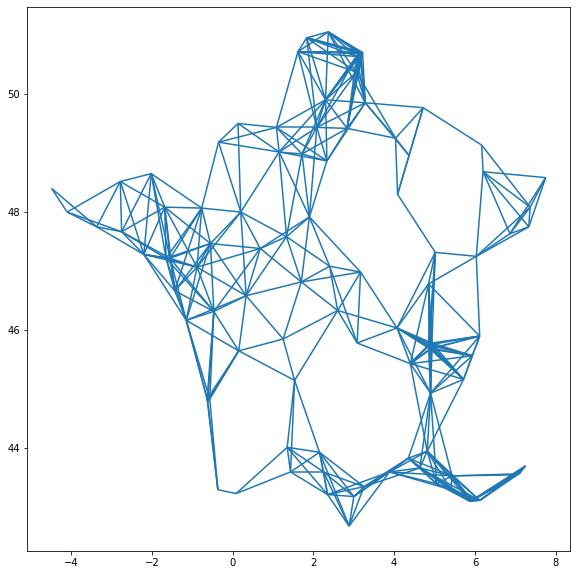

In [18]:
fig, ax = plt.subplots(figsize=(10, 10)) 

gdf.plot(ax=ax)

plt.show()

In [19]:
name_cities=final_cities.drop([1,73], axis=0)['nom']


In [20]:
dic_shortest_paths={}
for el in name_cities: 
    dic_city={}
    path =nx.dijkstra_path(G,'Marseille',el)
    dic_city["path"]=path
    distances=[]
    accumulated_distance=0
    for i in range(1,len(path)) : 
        accumulated_distance+=g[path[i]][path[i-1]]['weight']
        distances.append(accumulated_distance)
    dic_city["distances"]=distances
    dic_shortest_paths[el]=dic_city

In [21]:
graphe = final_cities
g_shortest = {nom: {} for nom in graphe.nom}

for el in dic_shortest_paths:
    #print(el)
    for j in range(len(dic_shortest_paths[el]['path'])-1):
        first=dic_shortest_paths[el]['path'][j]
        second=dic_shortest_paths[el]['path'][j+1]
        g_shortest[first][second] = {"weight": g[first][second]['weight']}
       


In [22]:
import networkx as nx
G_shortest = nx.from_dict_of_dicts(g_shortest)

In [23]:
rows_shortest = []
for (u, v) in G_shortest.edges:
    p1 = graphe[graphe["nom"] == u].geometry.iloc[0]
    p2 = graphe[graphe["nom"] == v].geometry.iloc[0]
    
    row = {'orig': u, 
           'dest': v,
           'geometry': LineString([p1, p2])}
    rows_shortest.append(row)

In [24]:
gdf = gpd.GeoDataFrame(rows_shortest, crs="EPSG:4326")

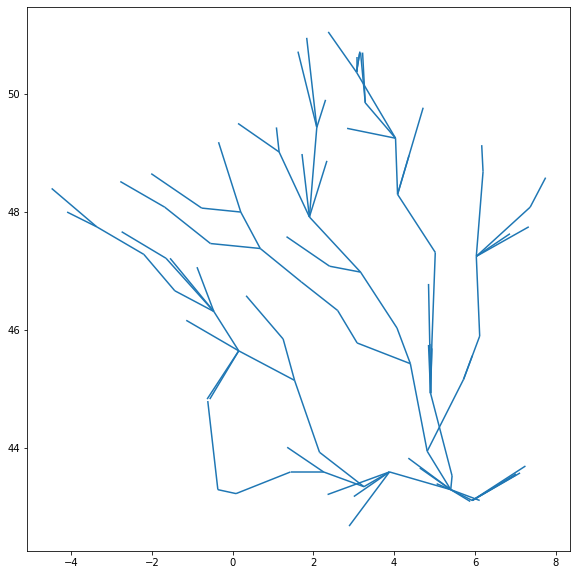

In [25]:
fig, ax = plt.subplots(figsize=(10, 10)) 

gdf.plot(ax=ax)

plt.show()

#shortest paths from Marseille

In [39]:
hubs_Marseille=set()
for el in dic_shortest_paths: 
    final_dist=dic_shortest_paths[el]["distances"][len(dic_shortest_paths[el]["distances"])-1]
    one_third=final_dist/3
    two_thirds=final_dist*2/3
    i= 0
    for i in range(len(dic_shortest_paths[el]["distances"])):
        if dic_shortest_paths[el]["distances"][i] > one_third and dic_shortest_paths[el]["distances"][i] < two_thirds:
            if dic_shortest_paths[el]["path"][i] not in hubs_Marseille: 
                hubs_Marseille.add(dic_shortest_paths[el]["path"][i+1])


In [41]:


list_hubs=[]
for el in hubs_Marseille: 
    list_hubs.append(el)
list_hubs.append("Marseille")
hubs=final_hubs[final_hubs["nom"].isin(list_hubs)]


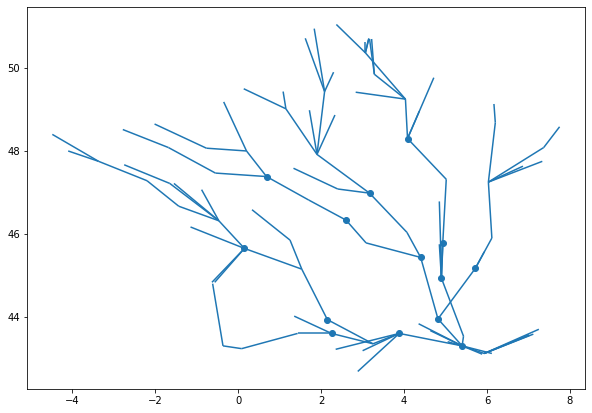

In [42]:
fig, ax = plt.subplots(figsize=(10, 10)) 

gdf.plot(ax=ax)
hubs.plot(ax=ax)

plt.show()

In [318]:
final_cities.iloc[:]["nom"]

0             Paris
1         Marseille
2              Lyon
3          Toulouse
4              Nice
           ...     
139          Nevers
140       Compiegne
141    Saint-Priest
142        LeCannet
143          Roanne
Name: nom, Length: 100, dtype: object

In [363]:
name_cities_to_investigate=final_cities.iloc[:]["nom"]
list_cities=[]
for el in name_cities_to_investigate: 
    list_cities.append(el)

In [397]:
def shortest_path_dict(city,index): 
    if (city!="Ajaccio"):
        dic_shortest_paths={}
        name_cities=list_cities[:index]+list_cities[index+1:]
        for el in name_cities: 
            if(el!="Ajaccio"):
                dic_city={}
                path =nx.dijkstra_path(G,city,el)
                #print(path)
                dic_city["path"]=path
                distances=[]
                accumulated_distance=0
                for i in range(1,len(path)) : 
                    accumulated_distance+=g[path[i]][path[i-1]]['weight']
                    distances.append(accumulated_distance)
                dic_city["distances"]=distances
                dic_shortest_paths[el]=dic_city
        return dic_shortest_paths
    return []
    

In [398]:
name_cities_to_investigate=final_cities['nom']
dict_shortest_paths_all={}
index=0
for city in name_cities_to_investigate:
    dict_shortest_paths_all[city]=shortest_path_dict(city,index)
    index+=1


dict_shortest_paths_all

{'Paris': {'Marseille': {'path': ['Paris',
    'Orleans',
    'Nevers',
    'Roanne',
    'Saint-Etienne',
    'Avignon',
    'Marseille'],
   'distances': [1.0440253828331916,
    2.6180790667969864,
    3.9251827352181294,
    4.613933052822412,
    6.154445305289101,
    7.027594204389367]},
  'Lyon': {'path': ['Paris', 'Orleans', 'Nevers', 'Roanne', 'Lyon'],
   'distances': [1.0440253828331916,
    2.6180790667969864,
    3.9251827352181294,
    4.757246434702729]},
  'Toulouse': {'path': ['Paris',
    'Orleans',
    'Chateauroux',
    'Limoges',
    'Brive-la-Gaillarde',
    'Toulouse'],
   'distances': [1.0440253828331916,
    2.162059371583088,
    3.2286375449956126,
    3.9836799279119655,
    5.536902384612869]},
  'Nice': {'path': ['Paris',
    'Orleans',
    'Nevers',
    'Roanne',
    'Valence',
    'Aix-en-Provence',
    'LeCannet',
    'Nice'],
   'distances': [1.0440253828331916,
    2.6180790667969864,
    3.9251827352181294,
    5.306984819454508,
    6.80501319034739

In [442]:
def calculate_hubs(city):
    hubs=set()
    print("ville est ")
    print(city)
    print(dict_shortest_paths_all[city])
    for el in enumerate(dict_shortest_paths_all[city]):
        print(el)
        final_dist=dict_shortest_paths_all[city][el]["distances"][len(dict_shortest_paths_all[city][el]["distances"])-1]
        one_third=final_dist/3
        two_thirds=final_dist*2/3
        i= 0
        #print(city)
        print(one_third)
        #for i in range(len(dic_shortest_paths[city][el]["distances"])):
            #if dic_shortest_paths[city][el]["distances"][i] > one_third and dic_shortest_paths[city][el]["distances"][i] < two_thirds:
                #if dic_shortest_paths[city][el]["path"][i] not in hubs: 
                    #hubs.add(dic_shortest_paths[city][el]["path"][i+1])
        
        return one_third


In [443]:
dict_hubs_all={}
for el in dict_shortest_paths_all:
    calculate_hubs(el)
    
    

ville est 
Paris
{'Marseille': {'path': ['Paris', 'Orleans', 'Nevers', 'Roanne', 'Saint-Etienne', 'Avignon', 'Marseille'], 'distances': [1.0440253828331916, 2.6180790667969864, 3.9251827352181294, 4.613933052822412, 6.154445305289101, 7.027594204389367]}, 'Lyon': {'path': ['Paris', 'Orleans', 'Nevers', 'Roanne', 'Lyon'], 'distances': [1.0440253828331916, 2.6180790667969864, 3.9251827352181294, 4.757246434702729]}, 'Toulouse': {'path': ['Paris', 'Orleans', 'Chateauroux', 'Limoges', 'Brive-la-Gaillarde', 'Toulouse'], 'distances': [1.0440253828331916, 2.162059371583088, 3.2286375449956126, 3.9836799279119655, 5.536902384612869]}, 'Nice': {'path': ['Paris', 'Orleans', 'Nevers', 'Roanne', 'Valence', 'Aix-en-Provence', 'LeCannet', 'Nice'], 'distances': [1.0440253828331916, 2.6180790667969864, 3.9251827352181294, 5.306984819454508, 6.8050131903473945, 8.3893780473169, 8.657665206905278]}, 'Strasbourg': {'path': ['Paris', 'Saint-Quentin', 'Charleville-Mezieres', 'Metz', 'Nancy', 'Strasbourg'],

KeyError: (0, 'Marseille')